# Topic Modeling

This topic modeling notebook is a tool for analyzing the collection of social media posts and identifying the main topics discussed within them. The algorithms compared are:


1.  Hierarchical Dirichlet Process (HDP) 
2.  Latent Dirichlet Allocation (LDA) 
3. Latent Semantic Indexing (LSI)
4. Non-Negative Matrix Factorization (NMF)

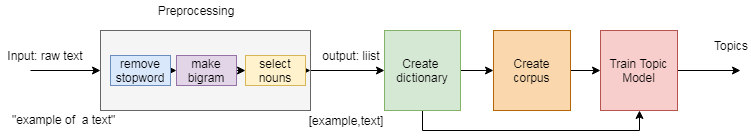

Image source: https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full

# Libraries

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import re
from unicodedata import normalize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#For Topic Visualization
#Install pyLDAVis (specific version for Google Collab)
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
!python -m spacy download es_core_news_lg

2022-11-13 00:44:20.815202: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.0 MB 8.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [ ]:
import spacy
nlp = spacy.load('/usr/local/lib/python3.7/dist-packages/es_core_news_lg/es_core_news_lg-3.4.0')

# Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Maestría/Estancia/aux/df_lem_spacy_ready.csv')
df.head()

,organizacion,link_desinformacion,texto_desinformacion,topic_desinformacion_raw,topic_desinformacion,label_desinformacion_raw,label_desinformacion,source_desinformacion_raw,source_desinformacion,formato_desinformacion,total_comments,total_reactions,total_shares,augmented,clean_texto,feat_word_count,feat_word_density,feat_characters,feat_upper_case,feat_hashtag,feat_find_url,feat_sentiment,feat_count_sentences,feat_polarity_score,feat_count_punctuation,feat_count_syllables,feat_count_emoticons,feat_ari,feature_ttr,feat_flesch_reading,count_organizations,count_persons,count_locations,count_pronouns,count_verbs,texto_emoji,texto_emoji_clean,texto_clean,text_lang,lang,long,mentions,hashtags,texto_lem
0,verificado,https://www.facebook.com/DisculpeLasMolestiasEstoEsUnaRevolucion/photos/basw.AboXK-oDbmrcxLersagjQXeXHA-ZS0zCSzaH0gy5bXMZlI5Wk71Af1feCnoyq6NPT0IboUbmxaQHMvZ5QRPYnHQuIDd3Jjo0fjvja1i6fx5j0_llxDtwEo_ycQJ7qC7ouKtcDQIrqdNMrc1gwSxffIq-tEFRTNDTJbIWmSy3yCvCU1QMynYX-M_B_eX_57evA4mrx8TiSFsN2HXYSc_qhyNt.1368609479857562.1048961835213764.1061098397352852.309848959410452.1893115200922435.351691281967239.1245400692208477.1372432589474736.1200289516693529/1893115200922435/?type=1&opaqueCursor=AbozcLnGbT-ciSJc8dmiONwtJ0r91aQoPfbPAWDUFkHZkYg1YTdnTUrmPGGTNSnoa_L3U8t03r8rYOACb-9ZFhsUzbDnYBkK-hYsM0kKafH7pKt2kaxQuynx6y94tkdPnlgqbUqwi75TR2BU9QCIgNZzIgoUfn81rbX9i2swvp-z2cRiRVePL3a9U_RbnImZnV4roxE993FS9IKA8j9TAUZrcu7BVlt0ajdfg-mhyq5vuzYpooRFsDcASJhNLHr5bc6nPzcZYvd6--bGXaO7o54O8NBIQAxEENLbxkwEaG5GZ0TOwkbIQadypCvcQlrnJWCMR7vX5R3oF64Ibf5tbyJXwsnBbXgx5oAc9iUr0OrGNg-KCgfqubpuGZRal_68Gw9u57yWgkT63pLYecFiy0gIomP4i3NgOA8pvwTt4uVEag1z5ODSgzBIcpiSgKm1Mb1tqKjgRYdBa3omF75RuALCy-fRziTUu0aDnEl4YidG7oPz4j6Us_TUVCKgOr2JORurJPtUHCT6H7e8_1TmhMg1BQOopxWj6pJPhdFn-56QXBS-ADpW2osxvd4dd4JCC-UiB2l_nuv5vuL_DMheichmIzfMj-FWrxQaNL7Dcx9YuFHuCsdDabMRSbkIxfu6ZR3Gq-oi0HZ8PTBRhgqD3bew&theater,"El Senador del ""PAN"" Javier Lozano, lo dejo bien Claro: ""Si me bajan el salario me pongo a robar"" Algo que no es novedad, SIEMPRE HA ROBADO!!\n\n¿Que les parece?",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,401,1186,6907,0,senador pan javier lozano dejar bajar salariar poner a robar novedad robadoque,12,1.000000,78,26,0,0,2.832097e-06,2,-1,11,50,0,14.2,0.933333,74.87,2,2,0,1,0,"El Senador del ""PAN"" Javier Lozano, lo dejo bien Claro: ""Si me bajan el salario me pongo a robar"" Algo que no es novedad, SIEMPRE HA ROBADO!!\n\n¿Que les parece?",senador pan javier lozano dejo bien claro si bajan salario pongo robar no novedad siempre robado parece,senador pan javier lozano dejo bien claro si bajan salario pongo robar no novedad siempre robado parece,"el senador del ""pan"" javier lozano, lo dejo bien claro: ""si me bajan el salario me pongo robar"" algo que no es novedad, siempre ha robado!! ¿que les parece?",es,17,[],[],senador pan javier lozano dejar bien claro si bajar salario poner robar no novedad siempre robado parecer
1,verificado,https://www.facebook.com/novoideass/photos/p.1942992509350897/1942992509350897/?type=1&opaqueCursor=AbpIpJLSjxhIhpJK5i_XKBoi48PCLT8p6dDpUNNcPA6FYx62sGmL3nNoayp0mDFqcRNr14S4zbD97S0bR1xz-gJSMSuO6iEvvNrTSbQvTEOPgEDmxyX2gBjMxhXkaKgY6XPXyjvUZKDlK11wLCSGBSksJOL0kYCUJuXSQ8fDYMGYhBdCSiMKfKeiWV4jU3yXA3-_TqTNmlzdde79PpMshGFgfQ-hfvSPH2-HK1ibC5b0rtXMmdD_tpm4uTxUvWU4k1pgMKefjTIFGPQJNznJjiXbA_J5hBSqxBv7NrccXIR-qu_cu2rgCZltJREHTi9UAmq0vgcWWTeOKQywpV-Q5ZtuzFSse29UalEpofAd1q3l_t7bA_GH4V_zjRWJaBSyR0LTMiMGaqL9JhRy2jmkqKCMrn1t_rLyGUdGsl8efZSv4A&theater,"El actor Gael García Bernal ha mostrado su simpatía por AMLO y hasta se enfrentó en una discusión con Javier Lozano Alarcón en Twitter. Además pidió a la Comisión de Derechos Humanos de la ONU que intervenga en la situación de inseguridad que se vive en México.\n-Imágen: Redes Sociales.\n""Libertad y República""",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,0,7,29,0,actor gael garcia bernal mostrar simpatia amlo y enfrentar discusion javier lozano alarcon twitter pidio a comisio

Selection of nouns, pronouns and verbs

In [ ]:
def nouns(texts, allowed_postags=['NOUN','PROPN','VERB']):
    texts_out = [token.text for token in nlp(texts) if token.pos_ in allowed_postags]
    return texts_out

In [ ]:
df['texto_topic'] = df.texto_lem_spacy.map(lambda x: nouns(x))

Remove single-word posts

In [ ]:
df = df[df.texto_topic.str.len()>1]
df.reset_index(drop=True,inplace=True)

Dic & Corpus

In [ ]:
dictionary = Dictionary(df['texto_topic'].to_list())
corpus = [dictionary.doc2bow(text) for text in df['texto_topic'].to_list()]

# Topic Modeling

## Hierarchical Dirichlet Process (HDP)

In [ ]:
#hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 245,alpha = 0.9,gamma = 0.8,kappa = 0.8, tau=60)
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 245)

/usr/local/lib/python3.7/dist-packages/gensim/models/hdpmodel.py:459: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [ ]:
#coherence 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=hdpmodel, texts= df.texto_cut, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7052853882848882


In [ ]:
 def display_topics(model, model_type="hdp"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx+1))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

In [ ]:
#hdpmodel.show_topics() 
display_topics(hdpmodel, model_type="hdp")

Topic 1:
virus  mms  coronaviru  enfermedad  gota  aire  beber  hacer  decir  proteccion 

Topic 2:
cadena  atraccion  arauz  hijo  alerta  tachar  pasar  secuestrar  char  cielo 

Topic 3:
reducir  audiencia  arrastrar  congreso  garrahan  ajustar  robo  respuesta  descubrimiento  hosp 

Topic 4:
voto  tomar  cuento  twitter  mostrar  virus  gente  reducir  orden  dar 

Topic 5:
aerolinea  vacuna  proteccion  pico  cumplir  vinagre  news  huawei  presentar  regalar 

Topic 6:
fruta  autorizar  montar  nino  reforzar  alistar  luz  gate  escuela  cometer 

Topic 7:
ver  considerar  policia  revisar  tomar  billete  matar  explotacion  bolsonaro  italia 

Topic 8:
gobierno  amigo  fda  analizar  pasaje  corea  publicar  beni  salir  minuto 

Topic 9:
acuerdo  cuerpo  verificacion  rostro  prestir  ciudadano  imponer  gate  mujer  producir 

Topic 10:
metro  edificio  familia  luis  numero  ee  llevar  pan  biden  tener 

Topic 11:
cuidado  cria  argumento  jesus  tomar  resucitar  mujic

## Latent Semantic Indexing (LSI) 


In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
display_topics(lsimodel)  # Showing the topics

Topic 1:
"virus"  "hacer"  "persona"  "decir"  "mms"  "enfermedad"  "coronaviru"  "salud"  "tomar"  "tener" 

Topic 2:
"gobierno"  "virus"  "beni"  "mms"  "mexico"  "salir"  "policia"  "felcn"  "vuelo"  "hacer" 

Topic 3:
"mms"  "virus"  "tomar"  "persona"  "coronaviru"  "gota"  "usar"  "estudio"  "dosis"  "guia" 

Topic 4:
"garrahan"  "virus"  "mujer"  "tinelli"  "dio"  "gobierno"  "cumplir"  "chico"  "sueno"  "objeto" 

Topic 5:
"fruta"  "cancer"  "comida"  "comer"  "agua"  "mms"  "beber"  "jugo"  "virus"  "vitamina" 



In [ ]:
#coherence 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lsimodel, texts= df.texto_cut, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4678181678456008


## Latent Dirichlet Allocation (LDA)

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=dictionary,
                   num_topics=5, 
                   random_state=698,
                   update_every=1,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts= df.texto_cut, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5046369825293937


In [ ]:
display_topics(lda_model, model_type="lda")

Topic 1:
buscar chile colombio mujer ciudad irani rey violencia hombre quedar 

Topic 2:
vida tragedia dio llama cancer provocar escasez salvar perder francisco 

Topic 3:
brasil mundo messi comenzar amor cubo cuba cara saber agua 

Topic 4:
eeuu crisis venezuelo trump pari volver segun millón periodista vender 

Topic 5:
mexico guerra nino rio noticia protesta pais morir dia decir 



In [ ]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.170070  0.120665       1        1  26.186300
3      0.081375  0.140396       2        1  22.639031
2     -0.092154  0.084279       3        1  19.916864
0      0.125703 -0.298515       4        1  17.578137
1     -0.284994 -0.046825       5        1  13.679668, topic_info=               Term        Freq       Total Category  logprob  loglift
19           mexico  945.000000  945.000000  Default  30.0000  30.0000
904            eeuu  561.000000  561.000000  Default  29.0000  29.0000
516            vida  338.000000  338.000000  Default  28.0000  28.0000
1502         brasil  385.000000  385.000000  Default  27.0000  27.0000
500           mundo  377.000000  377.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
584             afp   57.953929   59.647566   Topic5  -5.0045   1.9605
1803        refugio   66.804578   68.851347   Topic5  -4.8624   1.9591
2508          panda   67.481586   70.183358   Topic5  -4.8523   1.9500
670   contaminacion  103.518424  117.965746   Topic5  -4.4244   1.8586
2501       birmania   90.169583  114.575068   Topic5  -4.5625   1.7497

[220 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
304       1  0.987765       abrir
1903      2  0.983568  afganistan
584       5  0.972378         afp
763       3  0.764681        agua
763       5  0.227885        agua
...     ...       ...         ...
518       3  0.028893      volver
518       4  0.008255      volver
518       5  0.012383      volver
477       2  0.985754        york
2509      3  0.980935   zoologico

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

## Non-Negative Matrix Factorization (NMF)

In [ ]:
#Set topic modeling algorithm arguments

no_topics = 5 #@param {type:"integer"}

no_top_words = 10 #@param {type:"integer"}

no_top_documents = 0 #@param {type:"integer"}

In [ ]:
df['texto_topic_str'] = df.texto_topic.map(lambda x: ' '.join(x))

In [ ]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(str(doc_index))
            print(documents[doc_index])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer() #mix min df
tfidf = tfidf_vectorizer.fit_transform(df['texto_topic_str'].to_list())
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=90834).fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

print("NMF Topics")
display_topics(nmf_H, nmf_W, tfidf_feature_names, df['texto_topic_str'].to_list(), no_top_words, no_top_documents)
print("--------------")



NMF Topics
Topic 0:
hacer (1.06) coronaviru (0.87) decir (0.7) persona (0.5) gobierno (0.46) dar (0.42) ver (0.41) dia (0.4) mundo (0.37) pais (0.37)
Topic 1:
video (1.45) mostrar (1.32) foto (0.52) imagen (0.44) colombio (0.18) hombre (0.17) protesta (0.14) ecuador (0.12) venezuelo (0.11) montaje (0.11)
Topic 2:
paper (1.36) on (1.35) new (1.3) news (0.14) brasil (0.1) eeuu (0.1) pari (0.09) vez (0.07) accidente (0.07) bolsonaro (0.07)
Topic 3:
mexico (1.73) eeuu (0.97) ciudad (0.32) frontera (0.23) trump (0.21) presidente (0.2) imagen (0.18) sismo (0.16) protesta (0.11) obrador (0.1)
Topic 4:
covid (1.86) vacuna (0.82) foto (0.21) prueba (0.19) hospital (0.19) afirmación (0.16) prevenir (0.14) salud (0.11) enfermedad (0.11) vacunar (0.1)
--------------


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(nmf_model, tfidf, tfidf_vectorizer)
p

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.084320  0.021060       1        1  56.711424
3     -0.014173 -0.150841       2        1  13.932956
1     -0.041387 -0.237301       3        1  13.612471
4     -0.224027  0.244529       4        1  10.850037
2      0.363907  0.122553       5        1   4.893112, topic_info=            Term        Freq       Total Category  logprob  loglift
1601      mexico  207.000000  207.000000  Default  30.0000  30.0000
637        covid  174.000000  174.000000  Default  29.0000  29.0000
2545       video  175.000000  175.000000  Default  28.0000  28.0000
1654     mostrar  159.000000  159.000000  Default  27.0000  27.0000
1813       paper   90.000000   90.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1186      guerra    3.008202   17.900298   Topic5  -5.3910   1.2339
1667       mujer    3.043744   49.617239   Topic5  -5.3793   0.2261
414         caso    2.652286   25.468983   Topic5  -5.5169   0.7553
1971  presidente    2.677245   58.402817   Topic5  -5.5076  -0.0652
1477      llevar    2.508627   25.431918   Topic5  -5.5726   0.7011

[354 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
16        3  0.636960   accidente
16        5  0.318480   accidente
47        4  0.652891         adn
47        5  0.326446         adn
55        3  0.060880  afirmación
...     ...       ...         ...
2586      3  0.084461        york
2586      5  0.337845        york
2590      1  0.297954     zelanda
2590      3  0.893863     zelanda
2594      1  0.953950        zumo

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

# EXTRA: Sentiment Analysis

[pySentimiento](https://colab.research.google.com/github/pysentimiento/pysentimiento/blob/master/notebooks/PySentimiento_Sentiment_Analysis_in_Spanish.ipynb)

In [ ]:
!pip install pysentimiento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 7.8 MB/s 
     |████████████████████████████████| 312 kB 42.1 MB/s 
     |████████████████████████████████| 175 kB 31.6 MB/s 
     |████████████████████████████████| 880 kB 60.6 MB/s 
     |████████████████████████████████| 163 kB 53.7 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 115 kB 67.8 MB/s 
     |████████████████████████████████| 127 kB 62.1 MB/s 
     |████████████████████████████████| 110 kB 51.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=3fc69937338cc1904a55b7df8a2763550b25cdea68ec9840fb3b2d6b9cc8a416
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Some examples

In [ ]:
analyzer.predict('senador pan javier lozano dejo bien claro si bajan salario pongo robar no novedad siempre robado parece')

AnalyzerOutput(output=NEG, probas={NEG: 0.809, NEU: 0.188, POS: 0.003})

In [ ]:
analyzer.predict('sesinos dicen miedo contagiarse enfermedad covid carceles bueno amiguitos miedo tenia abuelita arrastraste tres cuadras quitarle jubilacion miedo tenia jovencito dirigio estudiar metiste plomazo robarle zapatillas miedo tenia jovencita violaste miedo tenia hombre mataste robarle pertenencias ahora salen aca huevadas no amigo derechos no existen violaste robaste asesinaste si mueren cumpliendo labor natural muera cumpliendo condena olvidaba decir ustedes comida segura dias aun dano dolor causado sociedad ninos padres estan abandonados hogar comida')

AnalyzerOutput(output=NEG, probas={NEG: 0.995, NEU: 0.005, POS: 0.000})

In [ ]:
analyzer.predict('Ante un sistema socialista (ideología basura propia de retardados) sucede lo siguiente: los millonarios (que no tienen nacionalidad se llevan sus millones antes de ser expropiados) los pobres y medio pobres; caen en pobreza alimentaria y la clase media desaparece al soportar ella sola con los exesivos impuestos los despilfarros en subsidios y dádivas que los dictadores populistas usan para tener borregos que los protejan y adoren... Así termina un país en dos clases: "los todos pobres" y la familia del dictador y su séquito de lambiscones. #NiUnVotoAmlo. #NoAlPopulismo #AmloDictador.')

AnalyzerOutput(output=NEG, probas={NEG: 0.998, NEU: 0.001, POS: 0.001})

In [ ]:
analyzer.predict('en tlaxcala... derramaron arbolitos de la banqueta nos quitaron la sombra de la av. independencia... únicamente para anunciar "al ricki". le valieron los arbolitos la sombra de la gente que caminamos por ahí... 😑 neta se manchan, culeros! cómo ellos no tienen que caminar ni la tienda... les vale!')

AnalyzerOutput(output=NEG, probas={NEG: 0.997, NEU: 0.002, POS: 0.001})

In [ ]:
analyzer.predict('*por* que los *infartos* 💔 ocurren más *menudo* en el *baño* 🚿 😲 ?? esto fue *escrito* por un profesor de *medicina* 📗 de la . . . en *malasia* , quien *aconseja* que la gente *no* debe *empezar* mojandose 💦 la *cabeza* el cabello cuando se *duchen* 🚿 por que esto es una secuencia *inversa* 😲 . *esto* causa que el cuerpo trate de *ajustar* su *temperatura* muy rápidamente por nuestra condición de ** *sangre* *caliente* ** . al hacer esta *secuencia* *incorrecta* , la sangre aumenta su *velocidad* para llegar más *rápidamente* la *cabeza* 😡 para *compensar* la diferencia de *temperatura* 💉 lo que eventualmente puede causar *roturas* de vasos *capilares* , *arterias* por consiguiente un *infarto* 💔 *caídas* 🤾‍♂ . la forma *correcta* de iniciar la *ducha* 🚿 es comenzar mojandose los *pies* 👣 , las *piernas* 🏃‍♂ gradualmente hasta los *hombros* al último la *cabeza* 🤨 . se debe evitar realizar la masturbacion bajo la ducha, en la tina, ( mucho menos si el agua esta caliente) ya que cuando se llega al climax, las pulsaciones del corazon se aceleran causando una abrupta subida de la tencion, lo que puede ocacionar un acv un infarto. 💔 *siga* estas *instrucciones* luego complete su *ducha* 🚿 normalmente esto es especialmente *recomendable* en quienes son *hipertensos* , tienen niveles *altos* de *colesterol* incluso padecen *migrañas* 🤯 . *por* *fin* !!! *una* *cadena* *muy* *útil* 🍎 *presión* *arterial* ☑ 120 / 80 *normal* ☑ 130 / 85 normal ( *control* ) ❌ *140 / 90 alta* ❌ 150 / 95 muy alta *el* *corazón* 💖 *late* ☑ 72 minuto ( *estándar* ) ☑ 60 - 80 pm ( *normal* ) ❌ 40 - 180 pm ( anormal ) *temperatura* ❗ ☑ 36. ( *normal* ) ❌ 37. ( fiebre 😡 ) *efectos* *del* *agua* 💦. *sabemos* que el *agua* 💦 es *importante* , pero *no* sabíamos la *hora* 🕐 *correcta* para *beber* !!! *sabias* que el *_agua_* 💦 potable en la *hora* 🕐 correcta *maximiza* la *eficacia* del *cuerpo* humano 🚶‍♂ . 💦 * taza ☕ de agua después de despertar* 😮 *ayuda* habilitar *órganos* internos . 💦 taza ☕ de agua *30* minutos 🕐 *antes* de la *comida* 🥗 *ayuda* la *digestión* . 💦 taza ☕ de agua *antes* de tomar *baño* 🚿 ayuda *descargar* la presión *arterial* . 💦 * taza de agua antes de dormir* 😴 ayuda *evitar* el derrame *cerebral* un *ataque* al *corazón* 💖 . cuando *alguien* tiene una *información* 📜 *importante* que puede *ayudar* nuestros *semejantes* 👨‍👩‍👧‍👧 tiene la *obligación* moral de *compartirla* 👨‍💻 📱 . los *amigos* 👬 son *como* una ** 😊 : te *llaman* ☎ 📱 te *buscan* 🕵‍♂ 🔍 te *cuidan* 💖 te *ven* 👀 🙄 te *escuchan* 👂 🤔 te *consuelan* 🤣 😘 te *perdonan* 🛐 te *salvan* 💪 te *protegen* 💂‍♂ *sobre* *todo* te *quieren* 😍 😇 *envíalo* 👨‍💻 📱 las *personas* que *no* te *arrepientes* 😄 de haber *conocido* 😘 .')

AnalyzerOutput(output=NEG, probas={NEG: 0.795, NEU: 0.203, POS: 0.003})

In [ ]:
analyzer.predict('incipios de septiembre de este año, ivanka trump, hija del presidente de eeuu, estuvo de gira "empresarial" por la región. en argentina, "casualmente" eligió visitar jujuy. miren quienes estaban en la comitiva junto al cipayo de morales... siiii!!! camacho la recientemente "autoproclamada" presidente provisional de bolivia, jeanine áñez. ahora decime que lo de bolivia fue espontáneo. 😡🤬 (década dédécada ganada unidad ciudadanaadécada ganada unidad ciudadanandécada gana... ver más	es')

AnalyzerOutput(output=NEU, probas={NEU: 0.945, NEG: 0.044, POS: 0.011})

In [ ]:
analyzer.predict('En Tlaxcala... Derramaron arbolitos de la banqueta y nos quitaron la sombra de la Av. independencia... Únicamente para anunciar "al Ricki". Le valieron los arbolitos y la sombra de la gente que caminamos por ahí... 😑 Neta se manchan, culeros! Cómo ellos no tienen que caminar ni a la tienda... Les vale!')

AnalyzerOutput(output=NEG, probas={NEG: 0.997, NEU: 0.002, POS: 0.001})

In [ ]:
analyzer.predict('médicos hacían operación de corazón de repente empezó el terremoto hoy en méxico, mantuvieron la calma orando nuestro señor jesús 😍')

AnalyzerOutput(output=NEU, probas={NEU: 0.886, POS: 0.106, NEG: 0.007})

In [ ]:
#quick cleaning
df['texto_sent'] = df.texto_desinformacion.str.replace('\n',' ')
df.texto_sent = df.texto_sent.map(lambda x: re.sub(r'\@\S+', ' ', x)) #quitamos @loQueSea

In [ ]:
df['sentiment_new'] = analyzer.predict(df.texto_sent)

  0%|          | 0/270 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 8620
  Batch size = 32


Saving results

In [ ]:
df.to_csv('df_sentiment.csv',index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Maestría/Estancia/aux/df_sentiment.csv')
df.head()

,organizacion,link_desinformacion,texto_desinformacion,topic_desinformacion_raw,topic_desinformacion,label_desinformacion_raw,label_desinformacion,source_desinformacion_raw,source_desinformacion,formato_desinformacion,total_comments,total_reactions,total_shares,augmented,clean_texto,feat_word_count,feat_word_density,feat_characters,feat_upper_case,feat_hashtag,feat_find_url,feat_sentiment,feat_count_sentences,feat_polarity_score,feat_count_punctuation,feat_count_syllables,feat_count_emoticons,feat_ari,feature_ttr,feat_flesch_reading,count_organizations,count_persons,count_locations,count_pronouns,count_verbs,texto_emoji,texto_emoji_clean,texto_clean,text_lang,lang,long,mentions,hashtags,texto_lem,texto_topic,texto_cut,texto_topic_str,texto_sent,sentiment_new
0,verificado,https://www.facebook.com/DisculpeLasMolestiasEstoEsUnaRevolucion/photos/basw.AboXK-oDbmrcxLersagjQXeXHA-ZS0zCSzaH0gy5bXMZlI5Wk71Af1feCnoyq6NPT0IboUbmxaQHMvZ5QRPYnHQuIDd3Jjo0fjvja1i6fx5j0_llxDtwEo_ycQJ7qC7ouKtcDQIrqdNMrc1gwSxffIq-tEFRTNDTJbIWmSy3yCvCU1QMynYX-M_B_eX_57evA4mrx8TiSFsN2HXYSc_qhyNt.1368609479857562.1048961835213764.1061098397352852.309848959410452.1893115200922435.351691281967239.1245400692208477.1372432589474736.1200289516693529/1893115200922435/?type=1&opaqueCursor=AbozcLnGbT-ciSJc8dmiONwtJ0r91aQoPfbPAWDUFkHZkYg1YTdnTUrmPGGTNSnoa_L3U8t03r8rYOACb-9ZFhsUzbDnYBkK-hYsM0kKafH7pKt2kaxQuynx6y94tkdPnlgqbUqwi75TR2BU9QCIgNZzIgoUfn81rbX9i2swvp-z2cRiRVePL3a9U_RbnImZnV4roxE993FS9IKA8j9TAUZrcu7BVlt0ajdfg-mhyq5vuzYpooRFsDcASJhNLHr5bc6nPzcZYvd6--bGXaO7o54O8NBIQAxEENLbxkwEaG5GZ0TOwkbIQadypCvcQlrnJWCMR7vX5R3oF64Ibf5tbyJXwsnBbXgx5oAc9iUr0OrGNg-KCgfqubpuGZRal_68Gw9u57yWgkT63pLYecFiy0gIomP4i3NgOA8pvwTt4uVEag1z5ODSgzBIcpiSgKm1Mb1tqKjgRYdBa3omF75RuALCy-fRziTUu0aDnEl4YidG7oPz4j6Us_TUVCKgOr2JORurJPtUHCT6H7e8_1TmhMg1BQOopxWj6pJPhdFn-56QXBS-ADpW2osxvd4dd4JCC-UiB2l_nuv5vuL_DMheichmIzfMj-FWrxQaNL7Dcx9YuFHuCsdDabMRSbkIxfu6ZR3Gq-oi0HZ8PTBRhgqD3bew&theater,"El Senador del ""PAN"" Javier Lozano, lo dejo bien Claro: ""Si me bajan el salario me pongo a robar"" Algo que no es novedad, SIEMPRE HA ROBADO!!\n\n¿Que les parece?",politica,politica nacional,falso,fake,facebook,redes_sociales,texto,401,1186,6907,0,senador pan javier lozano dejar bajar salariar poner a robar novedad robadoque,12,1.000000,78,26,0,0,2.832097e-06,2,-1,11,50,0,14.2,0.933333,74.87,2,2,0,1,0,"El Senador del ""PAN"" Javier Lozano, lo dejo bien Claro: ""Si me bajan el salario me pongo a robar"" Algo que no es novedad, SIEMPRE HA ROBADO!!\n\n¿Que les parece?",senador pan javier lozano dejo bien claro si bajan salario pongo robar no novedad siempre robado parece,senador pan javier lozano dejo bien claro si bajan salario pongo robar no novedad siempre robado parece,"el senador del ""pan"" javier lozano, lo dejo bien claro: ""si me bajan el salario me pongo robar"" algo que no es novedad, siempre ha robado!! ¿que les parece?",es,17,[],[],senador pan javier lozano dejar bien claro si bajar salario poner robar no novedad siempre robado parecer,"['senador', 'pan', 'javier', 'lozano', 'dejar', 'bajar', 'salario', 'poner', 'robar', 'novedad', 'parecer']","['senador', 'pan', 'javier', 'dejar', 'bajar', 'salario', 'poner', 'robar', 'parecer']",senador pan javier dejar bajar salario poner robar parecer,"El Senador del ""PAN"" Javier Lozano, lo dejo bien Claro: ""Si me bajan el salario me pongo a robar"" Algo que no es novedad, SIEMPRE HA ROBADO!! ¿Que les parece?","AnalyzerOutput(output=NEG, probas={NEG: 0.991, NEU: 0.008, POS: 0.001})"
1,verificado,https://www.facebook.com/novoideass/photos/p.1942992509350897/1942992509350897/?type=1&opaqueCursor=AbpIpJLSjxhIhpJK5i_XKBoi48PCLT8p6dDpUNNcPA6FYx62sGmL3nNoayp0mDFqcRNr14S4zbD97S0bR1xz-gJSMSuO6iEvvNrTSbQvTEOPgEDmxyX2gBjMxhXkaKgY6XPXyjvUZKDlK11wLCSGBSksJOL0kYCUJuXSQ8fDYMGYhBdCSiMKfKeiWV4jU3yXA3-_TqTNmlzdde79PpMshGFgfQ-hfvSPH2-HK1ibC5b0rtXMmdD_tpm4uTxUvWU4k1pgMKefjTIFGPQJNznJjiXbA_J5hBSqxBv7NrccXIR-qu_cu2rgCZltJREHTi9UAmq0vgcWWTeOKQywpV-Q5ZtuzFSse29UalEpofAd1q3l_t7bA_GH4V_zjRWJaBSyR0

In [ ]:
df.sentiment_new.values[0]

'AnalyzerOutput(output=NEG, probas={NEG: 0.991, NEU: 0.008, POS: 0.001})'

In [ ]:
df['sentiment_p'] = df.sentiment_new.str.split('=').str[2].str.split(':').str[1].str.split(',').str[0].astype(float)
df['sentiment_c'] = df.sentiment_new.str.split('=').str[1].str.split(',').str[0]

Histogram plot by sentiment prediction

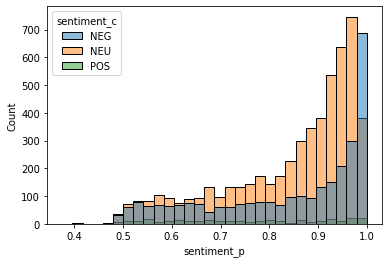

In [ ]:
sns.histplot(x= df.sentiment_p,hue=df.sentiment_c);

In [ ]:
df.groupby('sentiment_c').sentiment_p.describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_c,,,,,,,,
NEG,2898.0,0.837859,0.157541,0.376,0.7190,0.900,0.976,0.999
NEU,5423.0,0.845045,0.133672,0.390,0.7660,0.894,0.951,0.997
POS,299.0,0.754886,0.159559,0.398,0.6155,0.752,0.909,0.996


In [ ]:
df[df.sentiment_c=='POS'][['texto_sent']].sample(3)

,texto_sent
5959,Una indígena transgénero y una diseñadora colombianas conquistan las pasarelas
3855,La montaña con forma de elefante es obra de un artista
6254,"Alfonso Cuarón reinventó con ""Roma"" su forma de hacer cine - News Paper ON"


## EXTRA: Emotion Analysis

`pysentimiento` provides emotion analysis through models pre-trained with the datasets of [EmoEvent](https://github.com/fmplaza/EmoEvent-multilingual-corpus/)

In [ ]:
emotion_analyzer = create_analyzer(task="emotion", lang="es")

https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpweym7y08


Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/67cf0b22b25292bb1a3e1332f686c3c8cef2a203f1d7bccc6e801f16f7ae6e87.2e7a6ee7286c198ff851af16b0340004d73c5e8977413611e574ff14b9f7ff85
creating metadata file for /root/.cache/huggingface/transformers/67cf0b22b25292bb1a3e1332f686c3c8cef2a203f1d7bccc6e801f16f7ae6e87.2e7a6ee7286c198ff851af16b0340004d73c5e8977413611e574ff14b9f7ff85
loading configuration file https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/67cf0b22b25292bb1a3e1332f686c3c8cef2a203f1d7bccc6e801f16f7ae6e87.2e7a6ee7286c198ff851af16b0340004d73c5e8977413611e574ff14b9f7ff85
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classif

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/2f1a9c49582b07d3a39d108c5f099e762035431ed1169b22bb2d38fc3bfae48a.7d53b944be3007f8a318a47e5ce75f52dca2d342065e83317d1134583696cf31
creating metadata file for /root/.cache/huggingface/transformers/2f1a9c49582b07d3a39d108c5f099e762035431ed1169b22bb2d38fc3bfae48a.7d53b944be3007f8a318a47e5ce75f52dca2d342065e83317d1134583696cf31
loading weights file https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/2f1a9c49582b07d3a39d108c5f099e762035431ed1169b22bb2d38fc3bfae48a.7d53b944be3007f8a318a47e5ce75f52dca2d342065e83317d1134583696cf31
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at pysentimiento/robertuito-emotion

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/e5b58eb4110c09192df285dc3f632cae9b9474d810bb489a651effa5ddb2e2e9.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa20fd7dc8a3be740
creating metadata file for /root/.cache/huggingface/transformers/e5b58eb4110c09192df285dc3f632cae9b9474d810bb489a651effa5ddb2e2e9.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa20fd7dc8a3be740
https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp82g0kide


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/d36fe9b59af3e679efca2cfa00cffbc44be132ebc5ef39a61d32f5e60ee37ba2.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/d36fe9b59af3e679efca2cfa00cffbc44be132ebc5ef39a61d32f5e60ee37ba2.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpshtfitbz


Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/493237802ea94d02bfc7907883a3298b35a6cbd8d813fd11630c8c5056826a45.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7079b274f8613ae3
creating metadata file for /root/.cache/huggingface/transformers/493237802ea94d02bfc7907883a3298b35a6cbd8d813fd11630c8c5056826a45.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7079b274f8613ae3
loading file https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/d36fe9b59af3e679efca2cfa00cffbc44be132ebc5ef39a61d32f5e60ee37ba2.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/pysentimiento/robertuito-emotion-analysis/resolve/main/tokenize

In [ ]:
df['emotion_new'] = emotion_analyzer.predict(df.texto_sent.str.lower())

  0%|          | 0/270 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 8620
  Batch size = 32


In [ ]:
df['emotion_c'] = df.emotion_new.map(lambda x: x.output)
df['emotion_p'] = df.emotion_new.map(lambda x: x.probas)

In [ ]:
df.emotion_c.value_counts()

others      7722
anger        449
joy          213
sadness      199
surprise      15
fear          12
disgust       10
Name: emotion_c, dtype: int64

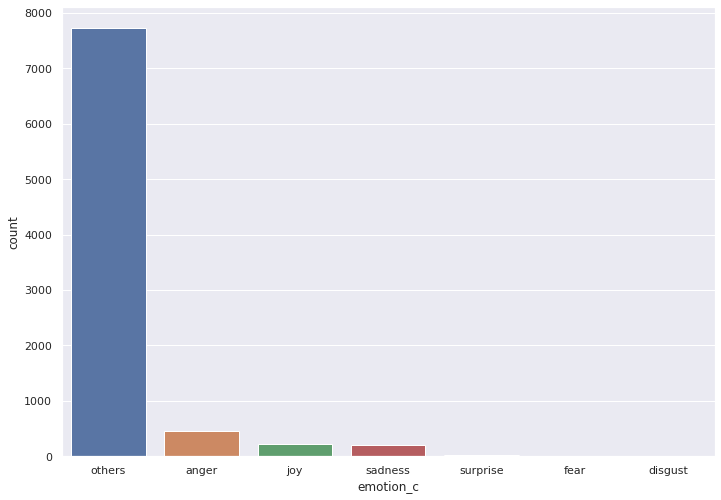

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='emotion_c', data=df);

## Hate Speech

In [ ]:
hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es")

https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplvbi86lp


Downloading:   0%|          | 0.00/956 [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/c798fcd43b0ff166a11ccb606e916eed37ea5800b4dd20ff2edd880fdb8a5cbd.29b427f0b44d35a50b9f730f9e93dbf914ed3fb60537c82b311e1f4732dfdcca
creating metadata file for /root/.cache/huggingface/transformers/c798fcd43b0ff166a11ccb606e916eed37ea5800b4dd20ff2edd880fdb8a5cbd.29b427f0b44d35a50b9f730f9e93dbf914ed3fb60537c82b311e1f4732dfdcca
loading configuration file https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c798fcd43b0ff166a11ccb606e916eed37ea5800b4dd20ff2edd880fdb8a5cbd.29b427f0b44d35a50b9f730f9e93dbf914ed3fb60537c82b311e1f4732dfdcca
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-hate-speech",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": n

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0f783b30471b13a04879e5c7f59ffb7e46b2aa6070bfc1de054e22f3730876b4.55428a0f24699e85f25e62ebe82b655dc72cfe0abf1f37e9b20c3d41978bbcf0
creating metadata file for /root/.cache/huggingface/transformers/0f783b30471b13a04879e5c7f59ffb7e46b2aa6070bfc1de054e22f3730876b4.55428a0f24699e85f25e62ebe82b655dc72cfe0abf1f37e9b20c3d41978bbcf0
loading weights file https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0f783b30471b13a04879e5c7f59ffb7e46b2aa6070bfc1de054e22f3730876b4.55428a0f24699e85f25e62ebe82b655dc72cfe0abf1f37e9b20c3d41978bbcf0
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at pysentimiento/robertuito-hate-speech.
If y

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f151cdb0362e2cc8c419bd5878232bea313009ac93445c0f66bf43ea764cd71c.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa20fd7dc8a3be740
creating metadata file for /root/.cache/huggingface/transformers/f151cdb0362e2cc8c419bd5878232bea313009ac93445c0f66bf43ea764cd71c.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa20fd7dc8a3be740
https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbw8eq04o


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/29bbf6eb913fdd3d8aaabeec43896b21a574167c27d3a9a85fc9dc57eea39ace.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/29bbf6eb913fdd3d8aaabeec43896b21a574167c27d3a9a85fc9dc57eea39ace.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0fb1rli6


Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

storing https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/82bf0643b37bd3be5cb16b6646358a7e6c7de8829f035e79cdc14ad408ebf3ce.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7079b274f8613ae3
creating metadata file for /root/.cache/huggingface/transformers/82bf0643b37bd3be5cb16b6646358a7e6c7de8829f035e79cdc14ad408ebf3ce.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7079b274f8613ae3
loading file https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/29bbf6eb913fdd3d8aaabeec43896b21a574167c27d3a9a85fc9dc57eea39ace.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/pysentimiento/robertuito-hate-speech/resolve/main/tokenizer_config.json from c

In [ ]:
df['hate_new'] = hate_speech_analyzer.predict(df.texto_sent.str.lower())

  0%|          | 0/270 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 8620
  Batch size = 32


In [ ]:
df['hate_c'] = df.hate_new.map(lambda x: x.output)
df['hate_p'] = df.hate_new.map(lambda x: x.probas)

In [ ]:
df.hate_c.value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                 8190
[hateful]                           355
[hateful, aggressive]                57
[hateful, targeted, aggressive]      15
[hateful, targeted]                   3
Name: hate_c, dtype: int64

In [ ]:
df.to_csv('df_sentiment_final.csv',index=False)

    Saved file: df_sentiment_final.csv